# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Load Data

### 2.1 Load Images

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
train_images = tf.data.Dataset.list_files("aug_data/train/images/*.jpg", shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [8]:
test_images = tf.data.Dataset.list_files("aug_data/test/images/*.jpg", shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [9]:
val_images = tf.data.Dataset.list_files("aug_data/val/images/*.jpg", shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [10]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [11]:
train_labels = tf.data.Dataset.list_files("aug_data/train/labels/*.json", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [12]:
test_labels = tf.data.Dataset.list_files("aug_data/test/labels/*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [13]:
val_labels = tf.data.Dataset.list_files("aug_data/val/labels/*.json", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 2.3. Combine Labels and Images

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [16]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### 2.4 View Samples

In [17]:
data_samples = train.as_numpy_iterator()

In [18]:
res = data_samples.next()

2022-05-19 21:38:23.786922: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


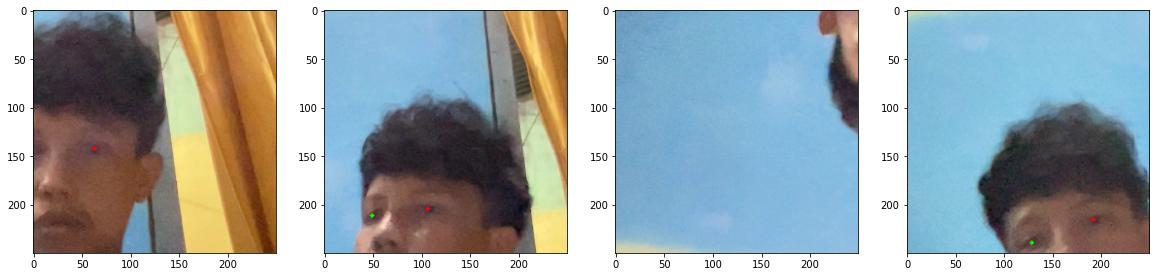

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

# 3. Build Model

### 3.1 Create Neural Network

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [21]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

234561536/234545216 [==============================] - 387s 2us/step


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 3.2 Setup Losses and Optimizer

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [24]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [25]:
X, y = train.as_numpy_iterator().next()

In [26]:
X.shape

(16, 250, 250, 3)

In [27]:
scores = model.predict(X)

2022-05-19 21:46:30.937801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [28]:
scores

array([[ 0.6231418 , -0.82857966,  0.6187531 , -1.5874991 ],
       [-0.07793206,  0.45384172,  1.1033876 , -0.83225507],
       [ 0.19650322,  0.08713078,  0.5069584 , -0.37448525],
       [ 0.5611354 , -0.2873669 ,  0.7561717 , -1.2132514 ],
       [ 0.34208232, -0.5719031 ,  1.208756  , -1.452107  ],
       [-0.04461242, -1.1068308 ,  0.38585812, -0.9677772 ],
       [ 0.6235379 , -0.51690936, -0.0905869 , -0.8980903 ],
       [ 0.6725031 ,  0.30234534,  0.22142172, -1.3558822 ],
       [-0.22468358,  0.26487908,  0.6718924 , -0.43228447],
       [-0.09544703, -0.47256607,  0.22500476, -1.1997871 ],
       [ 0.24415872,  0.08915916,  0.04223633, -0.6546971 ],
       [-0.3863734 , -0.2997546 ,  0.5887313 , -0.7956814 ],
       [ 0.5678537 , -0.96863353, -0.2509709 , -1.7223849 ],
       [ 0.8281634 , -0.29479012,  0.7265214 , -1.1309764 ],
       [ 0.17785765, -1.0093981 ,  0.48893565, -2.3468719 ],
       [-0.09105562, -0.54732996,  0.54806995, -0.65564513]],
      dtype=float32)

### 3.4 Train the Model

In [29]:
# Train for 100 epochs
hist = model.fit(train, epochs=1, validation_data=val)

2022-05-19 21:46:42.016963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


420/420 [==============================] - ETA: 0s - loss: 0.3989

2022-05-19 22:09:23.465227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


420/420 [==============================] - 1406s 3s/step - loss: 0.3989 - val_loss: 0.0261


# 4. Review Performance

### 4.1 View Loss Plots

In [30]:
hist.history

{'loss': [0.398869127035141], 'val_loss': [0.026052851229906082]}

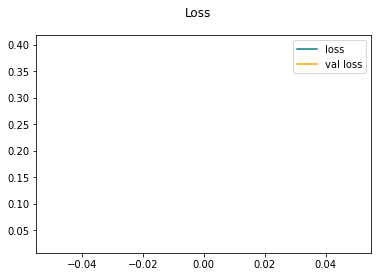

In [31]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2. Make Predictions on Test

In [32]:
test_data = test.as_numpy_iterator()

In [33]:
test_sample = test_data.next()

In [34]:
yhat = model.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


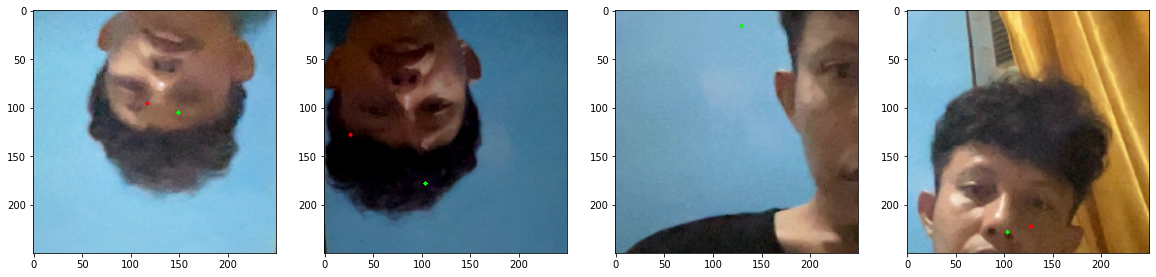

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### 4.3. Save the Model

In [36]:
from tensorflow.keras.models import load_model

In [37]:
model.save('eyetrackerresnet.h5')

In [38]:
model = load_model('eyetrackerresnet.h5')

In [39]:
model.predict(test_sample[0])

2022-05-19 22:11:01.068127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 6.06338692e+00, -1.24848068e+00,  1.02794533e+01,
        -2.07182083e+01],
       [-9.64563942e+00, -2.15662251e+01,  4.06658173e+00,
        -2.83130569e+01],
       [ 1.18295660e+01,  1.26586132e+01,  1.77097130e+01,
         6.01928616e+00],
       [-9.91957951e+00, -2.45308323e+01, -4.74680805e+00,
        -2.45237179e+01],
       [ 1.70187116e-01,  6.81740761e-01,  4.63587165e-01,
         7.72346020e-01],
       [ 3.31788063e-01,  1.22906975e-01,  6.37939751e-01,
         3.16215068e-01],
       [ 5.43052673e-01,  5.43422587e-02,  6.80609763e-01,
         1.52270168e-01],
       [-3.39945639e-03, -2.71709710e-02,  9.41109434e-02,
         1.28127322e-01],
       [-1.19681861e-02, -2.86783390e-02,  1.04391865e-01,
         8.31364989e-02],
       [ 2.23546512e-02,  4.39980656e-01,  2.80426532e-01,
         8.28644872e-01],
       [ 2.31855601e-01,  5.89018762e-01,  5.20177186e-01,
         6.10916972e-01],
       [ 7.35693276e-01,  5.16139030e-01,  7.60959014e-02,
      

# 5. Real Time Detection

In [40]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()